In [1]:
import os
import ogs6py
import vtuIO
import pandas as pd
import numpy as np
from scipy import special
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
from IPython.display import Image

# 1. Two-layer diffusion problem

## 1.1 Problem description

In waste repositories, radionuclide release can be expected after rupture of waste canisters to occur in the engineered barrier system, which contains multiple layers of materials and host rocks. In this benchamrk, a tracer (HTO) diffusion process through a two-layer barrier is simulated. The barrier is comprised of a bentonite buffer layer and an opalinus clay (OPA) layer. 

Over the one-dimensional model domain, the diffusion process of HTO can be described with the following governing equation:

$$
\frac{\partial \left( \phi c\right)}{\partial t} = \frac{\partial}{\partial x} \left( \phi \mathrm{D_p} \frac{\partial c}{\partial x} \right),
$$

where $c$ [mol/m$^3$] represents the HTO concentration. $\mathrm{D_p}$ [m$^2$/s] is the pore diffusion coefficient for HTO, and $\phi$ [-] is the porosity of the media.

## 1.2 Model setups

The computational domain is assumed to be 20 meters long. It consists of a 0.625 meter thick layer of bentonite buffer, and the rest is filled with OPA. The simulation time is one million years. Initially, the entire domain is assumed to be solute free, i.e. $c_{\mathrm{ini}}(x, 0) = 0$. The inlet concentration is held at 1 mol/L throughout the simulation, i.e. $c(0, t) = 1$ mol/L. In the numerical model, the spatial domain is discretized by linear line elements with a length of 0.005 meter each. The time step size of 1000 years is used in the simulation. The discretized governing equation is iteratively solved using the Newton-Raphson method.

The table below summarizes the parameters used in the simulation.

| Parameter | Value | Unit |
| :-: | :-: | :-: |
| Porosity of bentonite $\phi_{\mathrm{b}}$ | 0.36 | - |
| Porosity of OPA $\phi_{\mathrm{OPA}}$ | 0.12 | - |
| Pore diffusion coefficient in bentonite $\mathrm{D_{p,b}}$ | 5.55e-10 | m$^2$/s |
| Pore diffusion coefficient in OPA $\mathrm{D_{p,OPA}}$ | 8.33e-11 | m$^2$/s |
| Time step size $\Delta t$ | 1e3 | year |
| Grid size $\Delta x$ | 0.01 | m|

Notes: The parameter values are sourced from Nagra (2002).

## 1.3 Results

**Analytical solution**

For a two-layer diffusion problem, it is difficult to obtain the exact analytical solution. Instead, Carr and Turner (2016) presented a semi-analytical solution for this type of problem and released the corresponding <a href="https://github.com/elliotcarr/MultDiff">MATLAB script</a> for public usage.

Here we provide a <a href="https://gitlab.opengeosys.org/ogs/ogs/-/blob/master/Tests/Data/Parabolic/ComponentTransport/MultiLayerDiffusion/AnalyticalSolutionInput.m">MATLAB script</a> through which we can compute the concentration profiles along the two-layer domain. The following figure illustrates the concentration profiles at $t$ = 10$^3$, 10$^4$, 10$^5$, and 10$^6$ years (see calculated values in <a href="https://gitlab.opengeosys.org/ogs/ogs/-/blob/master/Tests/Data/Parabolic/ComponentTransport/MultiLayerDiffusion/SemiAnalyticalSolutionResults.csv">SemiAnalyticalSolutionResults.csv</a>).



In [2]:
#plot semi-analytical solution
#Time [year]
time = np.array([1e3, 1e4, 1e5, 1e6])

data_dir = os.environ.get('OGS_DATA_DIR', '../../../Data')
result_file = f"{data_dir}/Parabolic/ComponentTransport/MultiLayerDiffusion/SemiAnalyticalSolutionResults.csv"
soln = pd.read_csv(result_file, sep=',', header=None, skiprows=0, 
                       names=['x','1e3','1e4','1e5','1e6'], index_col=False)
    
def plot_analytical_solutions():
    fig, ax = plt.subplots()
    
    ax.set_xlim((0,20))
    ax.set_ylim((0,1))
    
    plt.xlabel('Distance [m]')
    plt.ylabel('HTO concentration [mol/L]')
    
    color_map=iter(cm.rainbow(np.linspace(0,1,len(time))))

    #represent the bentonite layer
    plt.axvspan(0, 0.625, facecolor='royalblue', alpha=0.2)
    #represent the OPA host rock
    plt.axvspan(0.625, 20, facecolor='orange', alpha=0.05)
    
    for col_name, t, color in zip(soln[['1e3','1e4','1e5','1e6']], time, color_map):
        ax.plot(soln['x'], soln[col_name], linestyle='-', lw=1.5,
                label=str(np.format_float_scientific(t))+' years',
                c=color, zorder=10, clip_on=False)
    
    ax.legend(frameon=False, loc='center right', numpoints=1, 
              fontsize=12, ncol=1)
    
    ax.xaxis.grid(color='gray', linestyle='dashed')
    ax.yaxis.grid(color='gray', linestyle='dashed')
    
plot_analytical_solutions()

FileNotFoundError: [Errno 2] No such file or directory: '../../../Data/Parabolic/ComponentTransport/MultiLayerDiffusion/SemiAnalyticalSolutionResults.csv'

**Numerical solution**

Correspondingly, the OGS input files of this 1D mass transport benchmark can be found <a href="https://gitlab.opengeosys.org/ogs/ogs/-/blob/master/Tests/Data/Parabolic/ComponentTransport/MultiLayerDiffusion/1D_MultiLayerDiffusion.prj">here</a>.

Then, the numerical solution by OpenGeoSys is plotted against the semi-analytical solution for comparison.

In [ ]:
#Run OGS simulation
prj_name = "1D_MultiLayerDiffusion"
data_dir = os.environ.get('OGS_DATA_DIR', '../../../Data')
prj_file = f"{data_dir}/Parabolic/ComponentTransport/MultiLayerDiffusion/{prj_name}.prj"
out_dir = os.environ.get('OGS_TESTRUNNER_OUT_DIR', '_out')

if not os.path.exists(out_dir):
    os.makedirs(out_dir)
os.chdir(out_dir)

print(f"ogs {prj_file} > out.txt")
! ogs {prj_file} > out.txt

#Read simulation results
pvdfile = vtuIO.PVDIO(f"{prj_name}.pvd", dim=1)

def plot_simulation_results():
    fig, ax = plt.subplots()
    
    ax.set_xlim((0,20))
    ax.set_ylim((0,1))
        
    plt.xlabel('Distance [m]')
    plt.ylabel('HTO concentration [mol/L]')

    #represent the bentonite layer
    plt.axvspan(0, 0.625, facecolor='royalblue', alpha=0.2)
    #represent the OPA host rock
    plt.axvspan(0.625, 20, facecolor='orange', alpha=0.05)
    
    color_map=iter(cm.rainbow(np.linspace(0,1,len(time))))
    
    #Plot semi-analytical solutions 
    for col_name, t, color in zip(soln[['1e3','1e4','1e5','1e6']], time, color_map):
        ax.plot(soln['x'], soln[col_name], linestyle='-', lw=1.5,
                c=color, zorder=10, clip_on=False)
    
    #Add simulation results
    x = np.linspace(0, 20, num=201)
    color_map=iter(cm.rainbow(np.linspace(0,1,len(time))))
    for t, color in zip(time, color_map):
        c_t = pvdfile.read_set_data(t*3.1536e7, 'HTO', data_type="point", pointsetarray=[(i,0,0) for i in x])
        plt.plot(x, c_t, label="Sim. "+str(np.format_float_scientific(t))+' years', 
                 color=color, marker='o', markevery=5, linestyle="", zorder=10, clip_on=False)
    
    ax.legend(frameon=False, loc='center right', numpoints=1, 
             fontsize=12, ncol=1)
    
    ax.xaxis.grid(color='gray', linestyle='dashed')
    ax.yaxis.grid(color='gray', linestyle='dashed')
    
plot_simulation_results()    

In the first time step, the semi-analytical and numerical solutions do not agree so well. As the time step progresses, they begin to agree more closely.

**Mass flux calculation**

Here is a sketch that shows how we calculate the molar flux at the node.

![sketch_molar_flux_calculation.jpg](sketch_molar_flux_calculation.jpg)
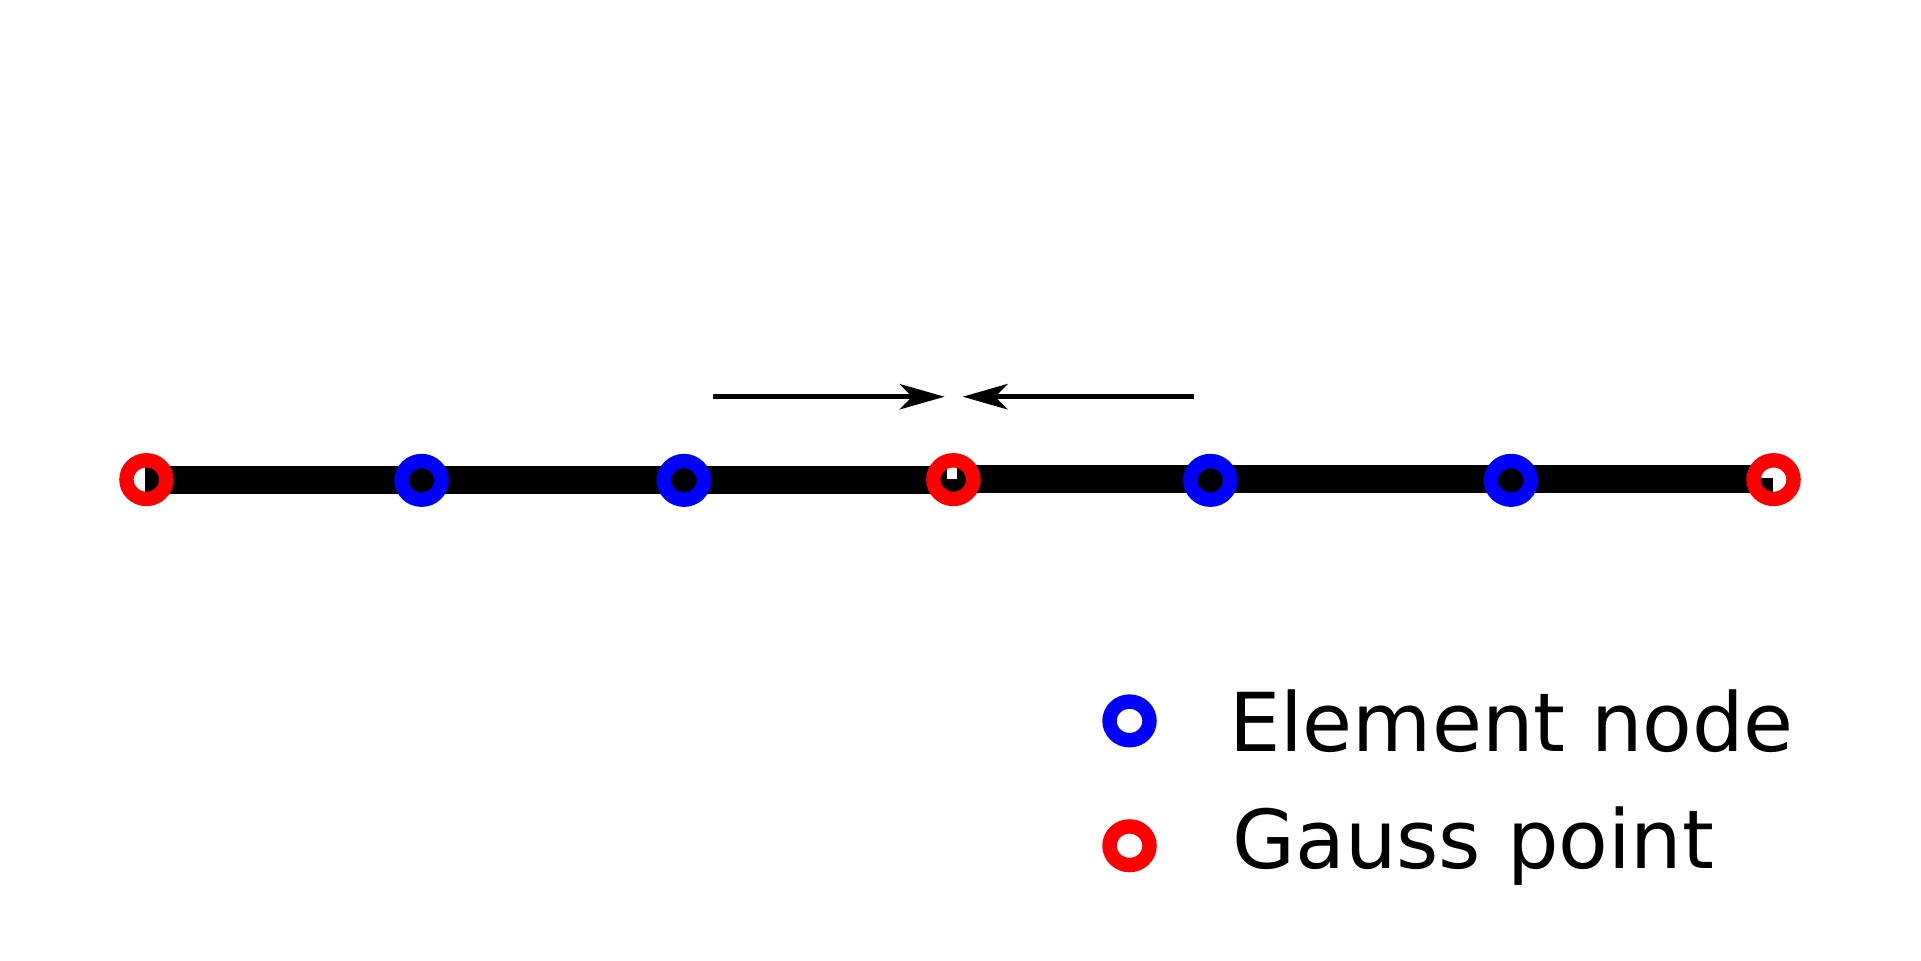

Additionally, we compute the molar flux profiles at $t$ = 10$^3$, 10$^4$, 10$^5$, and 10$^6$ years. The implementation of molar flux output can be viewed <a href="https://gitlab.opengeosys.org/ogs/ogs/-/merge_requests/4006">at this link</a>.

In [ ]:
def plot_molar_flux():
    fig, ax = plt.subplots()
    
    ax.set_xlim((0,20))
        
    plt.xlabel('Distance [m]')
    plt.ylabel('Mass flux [mol/m$^2$/s]')

    #represent the bentonite layer
    plt.axvspan(0, 0.625, facecolor='royalblue', alpha=0.2)
    #represent the OPA host rock
    plt.axvspan(0.625, 20, facecolor='orange', alpha=0.05)
    
    #plot total mass flux
    x = np.linspace(0, 20, num=201)
    color_map=iter(cm.rainbow(np.linspace(0,1,len(time))))
    for t, color in zip(time, color_map):
        c_t = pvdfile.read_set_data(t*3.1536e7, 'molar_flux', data_type="point", pointsetarray=[(i,0,0) for i in x])
        plt.plot(x, c_t, label="Sim. "+str(np.format_float_scientific(t))+' years', 
                 color=color, linestyle='-', lw=1.5, zorder=10, clip_on=False)
    
    ax.legend(frameon=False, loc='center right', numpoints=1, 
             fontsize=12, ncol=1)
    
    ax.xaxis.grid(color='gray', linestyle='dashed')
    ax.yaxis.grid(color='gray', linestyle='dashed')
    
plot_molar_flux()    

## References

<a href="https://www.nagra.ch/de/technical-report-02-06">Nagra, 2002</a>. Project Opalinus Clay: Models, Codes and Data for Safety Assessment. Technical Report NTB 02–06. Nagra, Switzerland.

E. J. Carr and I. W. Turner (2016), A semi-analytical solution for multilayer diffusion in a composite medium consisting of a large number of layers, Applied Mathematical Modelling, 40: pp. 7034–7050. http://dx.doi.org/10.1016/j.apm.2016.02.041

**Credits:**

Renchao Lu, Dmitri Naumov, Lars Bilke, Christoph Lehmann, Haibing Shao